## 1. SetUp

In [1]:
!pip install torch torchvision scikit-learn matplotlib ultralytics umap

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.6 MB/s eta 0:00:00
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=ddb3

In [2]:
import os, gc, json, shutil, yaml, warnings, random, math, copy
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
import umap.umap_ as umap

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from ultralytics import YOLO


warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42); random.seed(42); np.random.seed(42)
torch.backends.cudnn.benchmark = True
print("Device:", device, "| torch", torch.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="J1rWUvuwvKwOyLI5ooEK")
project = rf.workspace("sanjana-kazi-supti-ymhu2").project("final-1yr0d-wo5ot")
version = project.version(1)
dataset = version.download("coco")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 84.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30


Extracting Dataset Version Zip to Final-1 in coco:: 100%|██████████| 4295/4295 [00:01<00:00, 3158.52it/s]


In [4]:
import json
from pathlib import Path

# ===== Path to your COCO dataset folder =====
dataset_dir = Path("/kaggle/working/Final-1")

# ===== Function to convert JSON to single-class =====
def convert_to_one_class(json_file):
    with open(json_file, "r") as f:
        coco_data = json.load(f)

    # Step 1: Keep only one category
    coco_data["categories"] = [{"id": 1, "name": "Sunflower"}]

    # Step 2: Remap all annotations to category_id = 1
    for ann in coco_data["annotations"]:
        ann["category_id"] = 1

    # Step 3: Save back (overwrite original)
    with open(json_file, "w") as f:
        json.dump(coco_data, f, indent=2)

    print(f"Converted: {json_file}")

# ===== Loop over train, valid, test annotation files =====
for split in ["train", "valid", "test"]:
    json_path = dataset_dir / split / "_annotations.coco.json"
    if json_path.exists():
        convert_to_one_class(json_path)
    else:
        print(f"⚠ No JSON file found for {split}")

print("All done! Update YAML with:")
print('nc: 1\nnames: ["Sunflower"]')


Converted: /kaggle/working/Final-1/train/_annotations.coco.json
Converted: /kaggle/working/Final-1/valid/_annotations.coco.json
Converted: /kaggle/working/Final-1/test/_annotations.coco.json
All done! Update YAML with:
nc: 1
names: ["Sunflower"]


In [5]:
# BASE  = Path("/kaggle/input/annotated-rice-panicle-image-from-bangladesh")
# WORK  = Path("/kaggle/working/rice_ssl")
# SPLIT = WORK / "0_yolo_split"
# DATA  = WORK / "data_rice.yaml"
# SSL_W = WORK / "BYOL_ssl_yolov11_backbone.pth"   # save neck/backbone weights only
# WORK.mkdir(parents=True, exist_ok=True)

## 2. Assign a detection Catch

In [6]:
def get_detect_module(model_module):
    """Return the Detect head (robust across YOLO versions)."""
    try:
        last = model_module.model[-1]
        if "Detect" in last.__class__.__name__:
            return last
    except Exception:
        pass
    cand = None
    for m in model_module.modules():
        if "Detect" in m.__class__.__name__:
            cand = m
    return cand if cand is not None else list(model_module.modules())[-1]


## 3. Dataset Path

In [7]:
COCO_ROOT     = Path("/kaggle/working/Final-1")  # folder containing train/ and valid/
TRAIN_IMG_DIR = COCO_ROOT / "train"
TRAIN_ANN     = TRAIN_IMG_DIR / "_annotations.coco.json"
VAL_IMG_DIR   = COCO_ROOT / "valid"
VAL_ANN       = VAL_IMG_DIR / "_annotations.coco.json"
WORK          = Path("/kaggle/working/SSL-BYOL")  # output directory (can rename)
SSL_W         = WORK / "BYOL_ssl_yolov10_backbone.pth"
WORK.mkdir(parents=True, exist_ok=True)

## 4. COCO→YOLO conversion

In [8]:
# Create output directory structure
for split in ["train", "valid", "test"]:
    for sub in ["images", "labels"]:
        (WORK / split / sub).mkdir(parents=True, exist_ok=True)

# Function to convert COCO bbox to YOLO format
def coco2yolo(box, w, h):
    x, y, w_box, h_box = box
    return ((x + w_box/2) / w, (y + h_box/2) / h, w_box / w, h_box / h)

# Convert one split from COCO to YOLO format
def convert(split, img_dir, ann_file, out_dir):
    with open(ann_file, "r") as f:
        coco = json.load(f)

    id2img = {img["id"]: img for img in coco["images"]}
    imgs_o = out_dir / split / "images"
    labs_o = out_dir / split / "labels"

    for ann in coco["annotations"]:
        img = id2img[ann["image_id"]]
        yolo_box = coco2yolo(ann["bbox"], img["width"], img["height"])
        cls = ann["category_id"] - 1  # Class index starts from 0 in YOLO
        label_path = labs_o / f"{Path(img['file_name']).stem}.txt"
        with open(label_path, "a") as f:
            f.write(f"{cls} " + " ".join(f"{v:.6f}" for v in yolo_box) + "\n")

    for img in coco["images"]:
        shutil.copy(img_dir / img["file_name"], imgs_o / img["file_name"])

# ----------------------------------------------------------------------------
# 1. Perform Conversion
# ----------------------------------------------------------------------------
convert("train", TRAIN_IMG_DIR, TRAIN_ANN, WORK)
convert("valid", VAL_IMG_DIR,   VAL_ANN,   WORK)
convert("test",  TRAIN_IMG_DIR, TRAIN_ANN, WORK)  # Optional test reuse


## 5. Save the YAML file

In [9]:
import yaml

cats  = json.load(open(TRAIN_ANN))["categories"]
names = [c["name"] for c in sorted(cats, key=lambda x: x["id"])]
data_cfg = {
    "path":  str(WORK),
    "train": "train/images",
    "val":   "valid/images",
    "test":  "test/images",
    "nc":    len(names),
    "names": names
}
DATA = WORK / "data_Sunflower.yaml"
(DATA).write_text(yaml.dump(data_cfg))

112

## 6. Set the Two-view function

In [10]:
class TwoView(Dataset):
    SUPP = ('*.jpg','*.JPG','*.jpeg','*.JPEG','*.png','*.PNG','*.bmp','*.BMP','*.webp','*.WEBP')
    def __init__(self, roots, tfm):
        self.files=[]
        for r in roots:
            pr=Path(r)
            for p in self.SUPP:
                self.files.extend(pr.rglob(p))
        if not self.files: raise RuntimeError(f"No images found under {roots}")
        self.tfm=tfm
    def __len__(self): return len(self.files)
    def __getitem__(self,idx):
        img=Image.open(self.files[idx]).convert("RGB")
        return self.tfm(img), self.tfm(img)

augment = transforms.Compose([
    transforms.RandomResizedCrop(160, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3,0.3,0.3,0.1),
    transforms.RandomGrayscale(0.2),
    transforms.GaussianBlur(kernel_size=7, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
])

## 7. BYOL Loss Function and Detection hook

In [11]:
def byol_loss(p, z):
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return 2 - 2*(p*z).sum(dim=1).mean()

class DetectInputHook:
    def __init__(self, detect_module):
        self.handle = detect_module.register_forward_pre_hook(self.hook)
        self.feats = None
    def hook(self, module, inputs):
        # inputs is a tuple with a single item: a list/tuple of FPN maps [P3,P4,P5]
        self.feats = list(inputs[0])  # keep tensors with grad for online
        return None
    def close(self):
        self.handle.remove()

def global_pool_concat(feats):
    pooled = [F.adaptive_avg_pool2d(f, 1).flatten(1) for f in feats]
    return torch.cat(pooled, dim=1)

## 8. YOLOv11s model type backbone, optmizer setup, training loop and save the backbone weight

In [12]:
MODEL = "yolov10s.pt"     
SSL_EPOCHS, SSL_BATCH = 50, 64 # EPOCHS and BATCH SIZE
m0 = 0.996

if SSL_W.exists():
    print("BYOL backbone cached – skipping pre-train")
else:
    print("BYOL pre-training (1 epoch, hook-based, YOLOv10) …")

    # full models (we'll read neck features via hook)
    online_full = YOLO(MODEL).model.to(device)
    target_full = YOLO(MODEL).model.to(device)
    target_full.load_state_dict(online_full.state_dict())
    for p in target_full.parameters(): p.requires_grad=False

    # register hooks on Detect heads to capture P3,P4,P5
    online_hook = DetectInputHook(get_detect_module(online_full))
    target_hook = DetectInputHook(get_detect_module(target_full))

    # infer feature dim
    with torch.no_grad():
        dmy = torch.zeros(1,3,160,160,device=device)
        _ = online_full(dmy)                # run forward to populate hook
        feat_dim = global_pool_concat(online_hook.feats).shape[1]
    print("Backbone feature dim:", feat_dim)

    def projector():
        return nn.Sequential(
            nn.Linear(feat_dim,512,bias=False),
            nn.BatchNorm1d(512), nn.ReLU(inplace=True),
            nn.Linear(512,256,bias=False)
        )
    def predictor():
        return nn.Sequential(
            nn.Linear(256,512,bias=False),
            nn.BatchNorm1d(512), nn.ReLU(inplace=True),
            nn.Linear(512,256,bias=False)
        )

    proj_o, proj_t = projector().to(device), projector().to(device)
    pred_o         = predictor().to(device)
    proj_t.load_state_dict(proj_o.state_dict())
    for p in proj_t.parameters(): p.requires_grad=False

    # optimize only online_full (backbone+neck) + projector/predictor
    opt = torch.optim.AdamW(
        list(online_full.parameters()) + list(proj_o.parameters()) + list(pred_o.parameters()),
        lr=1e-3, weight_decay=1e-4
    )
    scaler = torch.amp.GradScaler(enabled=(device=="cuda"))

    @torch.no_grad()
    def ema_update(src, dst, m):
        for ps, pd in zip(src.parameters(), dst.parameters()):
            pd.data.mul_(m).add_(ps.data, alpha=1-m)

    def momentum_scheduled(step, total_steps, base=m0):
        if total_steps <= 1: return 1.0
        tau = step / (total_steps - 1)
        return 1.0 - (1.0 - base) * (0.5 * (1.0 + math.cos(math.pi * tau)))

    ds = TwoView([WORK/"train"/"images", WORK/"valid"/"images"], augment)
    dl = DataLoader(ds, batch_size=SSL_BATCH, shuffle=True,
                    num_workers=0, pin_memory=False, drop_last=True)

    total_steps = max(1, SSL_EPOCHS * len(dl))
    step = 0
    for ep in range(SSL_EPOCHS):
        online_full.train(); proj_o.train(); pred_o.train()
        running=0.0
        pbar = tqdm(dl, desc=f"BYOL {ep+1}/{SSL_EPOCHS}", leave=False)

        for v1,v2 in pbar:
            v1,v2 = v1.to(device, non_blocking=True), v2.to(device, non_blocking=True)
            m_cur = momentum_scheduled(step, total_steps)

            with torch.autocast(device_type='cuda', enabled=(device=="cuda")):
                # online encodes (features captured by hook)
                _ = online_full(v1)
                h1 = global_pool_concat(online_hook.feats)
                _ = online_full(v2)
                h2 = global_pool_concat(online_hook.feats)

                z1_o = proj_o(h1); z2_o = proj_o(h2)
                p1   = pred_o(z1_o); p2 = pred_o(z2_o)

                # target encodes (EMA, no grad)
                with torch.no_grad():
                    ema_update(online_full, target_full, m_cur)
                    ema_update(proj_o, proj_t, m_cur)
                    _ = target_full(v1)
                    h1_t = global_pool_concat(target_hook.feats)
                    _ = target_full(v2)
                    h2_t = global_pool_concat(target_hook.feats)
                    z1_t = proj_t(h1_t); z2_t = proj_t(h2_t)

                loss = byol_loss(p1, z2_t) + byol_loss(p2, z1_t)

            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True)
            running += loss.item()
            step += 1
            pbar.set_postfix(loss=f"{loss.item():.4f}", m=f"{m_cur:.4f}")

        print(f"Epoch {ep+1}/{SSL_EPOCHS} BYOL loss={running/len(dl):.4f}")

    # save ONLY backbone+neck weights (exclude Detect head)
    torch.save({k:v for k,v in online_full.state_dict().items()
                if not k.startswith('model.%d' % (len(online_full.model)-1))}, SSL_W)

    online_hook.close(); target_hook.close()
    del online_full, target_full, proj_o, proj_t, pred_o, dl, ds
    gc.collect(); 
    if device=="cuda": torch.cuda.empty_cache()
    print("✓ Saved SSL backbone weights →", SSL_W)

BYOL pre-training (1 epoch, hook-based, YOLOv10) …


Backbone feature dim: 896


BYOL 1/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1/50 BYOL loss=1.6031


BYOL 2/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 2/50 BYOL loss=1.4463


BYOL 3/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 3/50 BYOL loss=1.4241


BYOL 4/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 4/50 BYOL loss=1.3740


BYOL 5/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 5/50 BYOL loss=1.3206


BYOL 6/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 6/50 BYOL loss=1.2426


BYOL 7/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 7/50 BYOL loss=1.2121


BYOL 8/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 8/50 BYOL loss=1.1450


BYOL 9/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 9/50 BYOL loss=1.1291


BYOL 10/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 10/50 BYOL loss=1.1259


BYOL 11/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 11/50 BYOL loss=1.0778


BYOL 12/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 12/50 BYOL loss=1.0944


BYOL 13/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 13/50 BYOL loss=1.0595


BYOL 14/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 14/50 BYOL loss=1.0434


BYOL 15/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 15/50 BYOL loss=1.0343


BYOL 16/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 16/50 BYOL loss=1.0209


BYOL 17/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 17/50 BYOL loss=0.9965


BYOL 18/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 18/50 BYOL loss=0.9880


BYOL 19/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 19/50 BYOL loss=0.9846


BYOL 20/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 20/50 BYOL loss=0.9696


BYOL 21/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 21/50 BYOL loss=0.9667


BYOL 22/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 22/50 BYOL loss=0.9664


BYOL 23/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 23/50 BYOL loss=0.9470


BYOL 24/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 24/50 BYOL loss=0.9482


BYOL 25/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 25/50 BYOL loss=0.9499


BYOL 26/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 26/50 BYOL loss=0.9370


BYOL 27/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 27/50 BYOL loss=0.9199


BYOL 28/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 28/50 BYOL loss=0.9230


BYOL 29/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 29/50 BYOL loss=0.9292


BYOL 30/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 30/50 BYOL loss=0.9212


BYOL 31/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 31/50 BYOL loss=0.9268


BYOL 32/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 32/50 BYOL loss=0.9380


BYOL 33/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 33/50 BYOL loss=0.9306


BYOL 34/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 34/50 BYOL loss=0.9205


BYOL 35/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 35/50 BYOL loss=0.9202


BYOL 36/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 36/50 BYOL loss=0.9148


BYOL 37/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 37/50 BYOL loss=0.9246


BYOL 38/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 38/50 BYOL loss=0.9216


BYOL 39/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 39/50 BYOL loss=0.9039


BYOL 40/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 40/50 BYOL loss=0.9134


BYOL 41/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 41/50 BYOL loss=0.9059


BYOL 42/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 42/50 BYOL loss=0.9183


BYOL 43/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 43/50 BYOL loss=0.9034


BYOL 44/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 44/50 BYOL loss=0.9137


BYOL 45/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 45/50 BYOL loss=0.9223


BYOL 46/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 46/50 BYOL loss=0.9042


BYOL 47/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 47/50 BYOL loss=0.9010


BYOL 48/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 48/50 BYOL loss=0.9097


BYOL 49/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 49/50 BYOL loss=0.9139


BYOL 50/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 50/50 BYOL loss=0.9083
✓ Saved SSL backbone weights → /kaggle/working/SSL-BYOL/BYOL_ssl_yolov10_backbone.pth


## 9. Feature extraction plot (K-NN, PCA, t-SNE, UMAP)

➤ Loading BYOL feature extractor …
➤ Extracting features …


Extract train:   0%|          | 0/62 [00:00<?, ?it/s]

Extract val:   0%|          | 0/3 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7d24ed01efc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error



BYOL k-NN evaluation …
k-NN accuracy (val): 1.0000


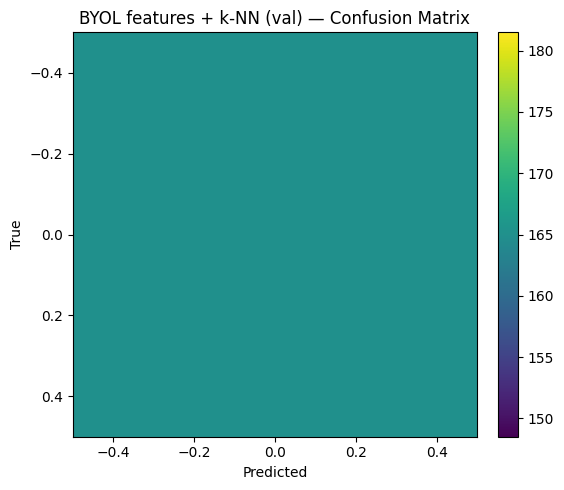

➤ Running PCA …
PCA 2D explained variance: 22.63%


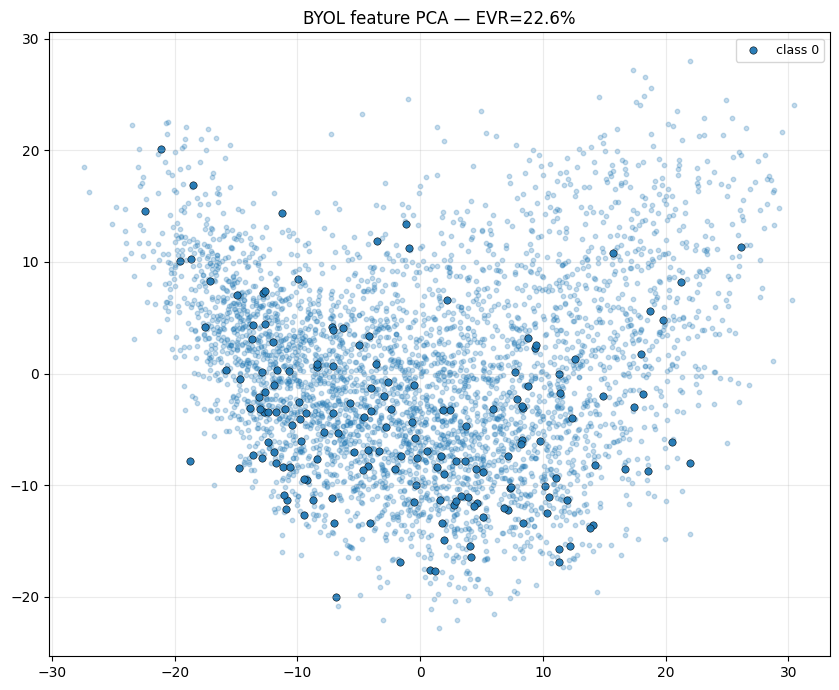

➤ Running t-SNE …


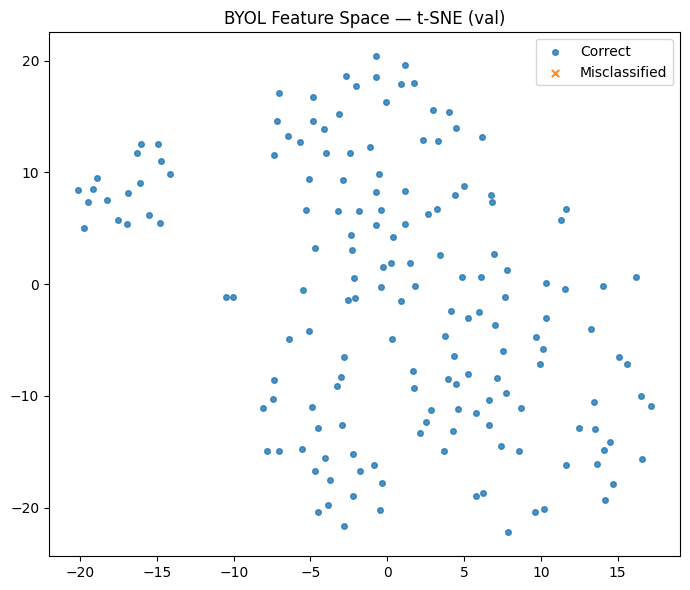

➤ Running UMAP …


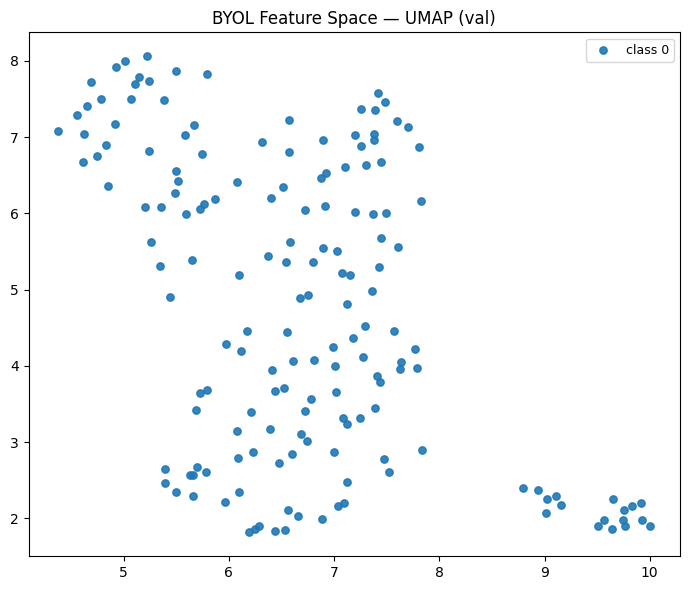


✓ All visualizations saved in: /kaggle/working/SSL-BYOL/plots


In [13]:
PLOTS  = WORK / "plots"
PLOTS.mkdir(parents=True, exist_ok=True)

# --- HELPERS ---
def imread_rgb(path: Path):
    return Image.open(path).convert("RGB")

def yolo_label_for_image(label_file: Path):
    if not label_file.exists():
        return None
    ids=[]
    with open(label_file) as f:
        for line in f:
            parts=line.strip().split()
            if parts:
                try: ids.append(int(parts[0]))
                except: pass
    return max(ids, key=ids.count) if ids else None

def list_images_and_labels(split_dir: Path):
    xs, ys = [], []
    images = sorted((split_dir/"images").glob("*.*"))
    for img_path in images:
        lb_path = (split_dir/"labels"/(img_path.stem + ".txt"))
        lab = yolo_label_for_image(lb_path)
        if lab is None:
            continue
        xs.append(img_path); ys.append(lab)
    return xs, np.array(ys, dtype=np.int64)

def get_detect_module(model_module):
    try:
        last = model_module.model[-1]
        if "Detect" in last.__class__.__name__:
            return last
    except Exception:
        pass
    cand = None
    for m in model_module.modules():
        if "Detect" in m.__class__.__name__:
            cand = m
    return cand if cand is not None else list(model_module.modules())[-1]

class DetectInputHook:
    def __init__(self, detect_module):
        self.handle = detect_module.register_forward_pre_hook(self.hook)
        self.feats = None
    def hook(self, module, inputs):
        self.feats = list(inputs[0])    # [P3,P4,P5]
        return None
    def close(self): self.handle.remove()

def global_pool_concat(feats):
    pooled = [F.adaptive_avg_pool2d(f, 1).flatten(1) for f in feats]
    return torch.cat(pooled, dim=1)

# --- DATA ---
train_X, train_y = list_images_and_labels(WORK/"train")
val_X,   val_y   = list_images_and_labels(WORK/"valid")
assert len(train_X) and len(val_X), "No labeled images found."

# --- FEATURE EXTRACTION ---
print("➤ Loading BYOL feature extractor …")
feat_model = YOLO("yolov10s.pt").model.to(device)
_ = feat_model.load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
feat_hook  = DetectInputHook(get_detect_module(feat_model))
feat_model.eval()

base_tfm = transforms.Compose([transforms.Resize((160,160)), transforms.ToTensor()])

class ImgDataset(Dataset):
    def __init__(self, paths, tfm): self.paths=paths; self.tfm=tfm
    def __len__(self): return len(self.paths)
    def __getitem__(self,i): return self.tfm(imread_rgb(self.paths[i]))

def extract_feats(paths, bs=64, desc="Extract"):
    ds  = ImgDataset(paths, base_tfm)
    dl  = DataLoader(ds, batch_size=bs, shuffle=False, num_workers=0, pin_memory=False)
    feats=[]
    for xb in tqdm(dl, total=len(dl), desc=desc, leave=False):
        xb = xb.to(device, non_blocking=True)
        with torch.no_grad():
            _ = feat_model(xb)
            h  = global_pool_concat(feat_hook.feats)
        feats.append(h.detach().cpu().numpy())
    return np.concatenate(feats, axis=0) if feats else np.zeros((0,1))

print("➤ Extracting features …")
train_F = extract_feats(train_X, bs=64, desc="Extract train")
val_F   = extract_feats(val_X,   bs=64, desc="Extract val")

feat_hook.close()
del feat_model
gc.collect()
if device=="cuda": torch.cuda.empty_cache()

# --- k-NN CLASSIFIER ---
print("\nBYOL k-NN evaluation …")
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(train_F, train_y)
val_pred = knn.predict(val_F)
acc = accuracy_score(val_y, val_pred)
print(f"k-NN accuracy (val): {acc:.4f}")

# Confusion matrix
cm = confusion_matrix(val_y, val_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("BYOL features + k-NN (val) — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(PLOTS/"knn_confusion_matrix.png", dpi=160)
plt.show()

# --- STANDARDIZE ---
scaler = StandardScaler(with_mean=True, with_std=True)
train_Fs = scaler.fit_transform(train_F)
val_Fs   = scaler.transform(val_F)

# --- PCA ---
print("➤ Running PCA …")
pca = PCA(n_components=2, random_state=42)
train_P = pca.fit_transform(train_Fs)
val_P   = pca.transform(val_Fs)
evr = pca.explained_variance_ratio_.sum()
print(f"PCA 2D explained variance: {evr*100:.2f}%")

plt.figure(figsize=(8.5,7))
classes = np.unique(np.concatenate([train_y, val_y]))
cmap = plt.get_cmap("tab10")
for c in classes:
    idx = np.where(train_y==c)[0]
    if len(idx):
        plt.scatter(train_P[idx,0], train_P[idx,1], s=10, alpha=0.25, color=cmap(int(c)%10))
for c in classes:
    idx = np.where(val_y==c)[0]
    if len(idx):
        plt.scatter(val_P[idx,0], val_P[idx,1], s=28, alpha=0.95, edgecolors='k', linewidths=0.4,
                    color=cmap(int(c)%10), marker='o', label=f"class {c}")
plt.title(f"BYOL feature PCA — EVR={evr*100:.1f}%")
plt.legend(fontsize=9, ncol=2, frameon=True)
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.savefig(PLOTS/"pca_train_val.png", dpi=160)
plt.show()

# --- t-SNE ---
if len(val_F) > 10:
    print("➤ Running t-SNE …")
    perplex = min(30, max(5, len(val_F)//10))
    tsne = TSNE(n_components=2, init="pca", learning_rate="auto",
                perplexity=perplex, n_iter=1000, random_state=42)
    Z_tsne = tsne.fit_transform(val_Fs)
    mistakes = (val_pred != val_y)
    plt.figure(figsize=(7,6))
    plt.scatter(Z_tsne[~mistakes,0], Z_tsne[~mistakes,1], s=16, label="Correct", alpha=0.8)
    plt.scatter(Z_tsne[mistakes,0],   Z_tsne[mistakes,1],   s=28, marker="x", label="Misclassified", alpha=0.9)
    plt.title("BYOL Feature Space — t-SNE (val)")
    plt.legend(); plt.tight_layout()
    plt.savefig(PLOTS/"tsne_val.png", dpi=160)
    plt.show()

# --- UMAP ---
print("➤ Running UMAP …")
umap_model = umap.UMAP(n_components=2, random_state=42)
Z_umap = umap_model.fit_transform(val_Fs)
plt.figure(figsize=(7,6))
for c in classes:
    idx = np.where(val_y==c)[0]
    plt.scatter(Z_umap[idx,0], Z_umap[idx,1], s=28, alpha=0.9, label=f"class {c}")
plt.title("BYOL Feature Space — UMAP (val)")
plt.legend(fontsize=9, ncol=2, frameon=True)
plt.tight_layout()
plt.savefig(PLOTS/"umap_val.png", dpi=160)
plt.show()

print("\n✓ All visualizations saved in:", PLOTS)

## 10. Load the backbone model and Fine-Tune with YOLOv11s Type detection Model

In [14]:
print("\n Fine-tuning YOLOv10-s (1 epoch) …")
det = YOLO(MODEL)  # nano to match SSL shapes
# load into all-but-Detect
sd = torch.load(SSL_W, map_location="cpu")
det.model.load_state_dict(sd, strict=False)

det.train(
    data=str(DATA),
    epochs=50,                # ← set to 1 epoch
    imgsz=640,
    batch=8,
    project=str(WORK),
    save = True,
    name="byol_yolo10s",
    device=0 if device=="cuda" else None,
    verbose=True
)



 Fine-tuning YOLOv10-s (1 epoch) …
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/SSL-BYOL/data_Sunflower.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=byol_yolo10s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1     36096  ultralytics.nn.modules.block.SCDown          [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1    137728  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2161.3±638.2 MB/s, size: 98.7 KB)


train: Scanning /kaggle/working/SSL-BYOL/train/labels... 3957 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3957/3957 [00:03<00:00, 1020.42it/s]


train: New cache created: /kaggle/working/SSL-BYOL/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 639.4±487.4 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/SSL-BYOL/valid/labels... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<00:00, 434.76it/s]

val: New cache created: /kaggle/working/SSL-BYOL/valid/labels.cache


Plotting labels to /kaggle/working/SSL-BYOL/byol_yolo10s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.0005), 111 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/SSL-BYOL/byol_yolo10s
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.666G      3.485      2.433      2.146        337        640: 100%|██████████| 495/495 [02:17<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.01it/s]

                   all        165      13823       0.75      0.742      0.809      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.37G       3.24      1.739      2.049        843        640: 100%|██████████| 495/495 [02:03<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]

                   all        165      13823      0.793      0.784      0.858      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.41G      3.198      1.685      2.028        774        640: 100%|██████████| 495/495 [02:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.09it/s]

                   all        165      13823      0.824      0.776      0.868      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.46G       3.13      1.644       2.01        486        640: 100%|██████████| 495/495 [02:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.09it/s]

                   all        165      13823      0.825      0.793      0.878      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       6.5G      3.072      1.581          2        492        640: 100%|██████████| 495/495 [02:01<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.10it/s]

                   all        165      13823      0.814      0.804      0.878      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.53G      3.014       1.54      1.975        617        640: 100%|██████████| 495/495 [02:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.09it/s]

                   all        165      13823      0.823      0.814      0.886      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.59G      2.991      1.518      1.973        859        640: 100%|██████████| 495/495 [02:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]

                   all        165      13823      0.804      0.806      0.878      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.64G      2.973      1.494      1.963        658        640: 100%|██████████| 495/495 [02:02<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]

                   all        165      13823      0.835      0.818      0.893      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.69G      2.947      1.479      1.956        648        640: 100%|██████████| 495/495 [02:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]

                   all        165      13823      0.826      0.817      0.887      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.73G      2.923      1.459      1.946        332        640: 100%|██████████| 495/495 [02:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]

                   all        165      13823      0.843      0.813      0.896      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.78G       2.91      1.446      1.946        282        640: 100%|██████████| 495/495 [02:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]

                   all        165      13823      0.838      0.817      0.894      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.82G      2.874      1.428      1.937        473        640: 100%|██████████| 495/495 [02:02<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]

                   all        165      13823      0.846      0.819        0.9      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.87G      2.868      1.406      1.936        578        640: 100%|██████████| 495/495 [02:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.15it/s]

                   all        165      13823      0.845      0.823      0.903      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.89G      2.874      1.415      1.936        414        640: 100%|██████████| 495/495 [02:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]

                   all        165      13823      0.843      0.817      0.899      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.96G      2.873      1.412      1.938        629        640: 100%|██████████| 495/495 [02:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]

                   all        165      13823      0.845      0.819      0.901      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         7G      2.823      1.384      1.927        509        640: 100%|██████████| 495/495 [02:01<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]

                   all        165      13823      0.848      0.824      0.901      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.05G      2.841      1.393      1.928        474        640: 100%|██████████| 495/495 [02:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]

                   all        165      13823      0.842      0.819      0.898      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.68G      2.819       1.38       1.92        825        640: 100%|██████████| 495/495 [02:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.16it/s]

                   all        165      13823      0.841      0.821      0.899      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.12G      2.807      1.368      1.919        656        640: 100%|██████████| 495/495 [02:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]

                   all        165      13823      0.837      0.833      0.903      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.65G      2.797      1.359      1.917        594        640: 100%|██████████| 495/495 [02:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.07it/s]

                   all        165      13823      0.826      0.832      0.898      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.65G      2.773      1.348      1.914        570        640: 100%|██████████| 495/495 [02:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]

                   all        165      13823      0.843      0.829      0.904      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.65G      2.774      1.341      1.911        535        640: 100%|██████████| 495/495 [02:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]

                   all        165      13823       0.84      0.828      0.902       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.26G      2.776      1.343      1.912        301        640: 100%|██████████| 495/495 [02:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]

                   all        165      13823      0.844      0.821      0.901      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       5.3G      2.761      1.336       1.91        467        640: 100%|██████████| 495/495 [02:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.15it/s]

                   all        165      13823      0.844      0.827      0.904      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.35G      2.731       1.32      1.899        633        640: 100%|██████████| 495/495 [02:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.09it/s]

                   all        165      13823      0.848      0.827      0.905      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.39G      2.746      1.321      1.901        264        640: 100%|██████████| 495/495 [02:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]

                   all        165      13823      0.844      0.826      0.902      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.44G      2.735       1.31      1.903        462        640: 100%|██████████| 495/495 [02:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]

                   all        165      13823      0.847      0.833      0.906      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.48G      2.724      1.304      1.898        579        640: 100%|██████████| 495/495 [02:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.17it/s]

                   all        165      13823       0.85      0.829      0.907      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.53G      2.708      1.293      1.894        670        640: 100%|██████████| 495/495 [02:01<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]

                   all        165      13823      0.847      0.836      0.908       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.55G      2.705      1.294      1.891        230        640: 100%|██████████| 495/495 [02:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.11it/s]

                   all        165      13823      0.846      0.833      0.907      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.62G      2.702      1.287      1.892        455        640: 100%|██████████| 495/495 [02:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]

                   all        165      13823      0.859      0.829      0.908      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.66G      2.704      1.292      1.889        407        640: 100%|██████████| 495/495 [02:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]

                   all        165      13823      0.849      0.833      0.908      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.71G      2.697      1.287      1.889        322        640: 100%|██████████| 495/495 [02:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.07it/s]

                   all        165      13823      0.845      0.833      0.908      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.75G       2.68      1.274       1.88        276        640: 100%|██████████| 495/495 [02:03<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]

                   all        165      13823       0.86      0.827       0.91      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       5.8G      2.689      1.276      1.883        729        640: 100%|██████████| 495/495 [02:03<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]

                   all        165      13823      0.855      0.835      0.912      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.85G      2.666      1.266      1.879        582        640: 100%|██████████| 495/495 [02:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.08it/s]

                   all        165      13823      0.849      0.837       0.91      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.89G      2.655      1.254      1.872        490        640: 100%|██████████| 495/495 [02:03<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]

                   all        165      13823      0.862      0.829      0.912      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.92G      2.645      1.252      1.875        586        640: 100%|██████████| 495/495 [02:03<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]

                   all        165      13823      0.851       0.84      0.912      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.98G      2.644      1.246      1.873        421        640: 100%|██████████| 495/495 [02:02<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]

                   all        165      13823      0.853      0.838      0.913      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.03G      2.633      1.245      1.872        483        640: 100%|██████████| 495/495 [02:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.16it/s]

                   all        165      13823      0.854      0.841      0.912      0.583


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.07G      2.622      1.218      1.895        279        640: 100%|██████████| 495/495 [01:52<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.16it/s]

                   all        165      13823      0.849      0.837      0.909      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.12G      2.595      1.203      1.882        263        640: 100%|██████████| 495/495 [01:51<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.16it/s]

                   all        165      13823      0.855       0.84      0.912      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.16G      2.581      1.195      1.883        389        640: 100%|██████████| 495/495 [01:51<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.14it/s]

                   all        165      13823      0.861      0.834      0.913      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.21G      2.562      1.183      1.877        476        640: 100%|██████████| 495/495 [01:51<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.13it/s]

                   all        165      13823      0.853       0.84      0.912      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.26G      2.555      1.179      1.875        509        640: 100%|██████████| 495/495 [01:51<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.12it/s]

                   all        165      13823      0.865      0.836      0.914      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.28G      2.541      1.172      1.872        336        640: 100%|██████████| 495/495 [01:51<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.15it/s]

                   all        165      13823      0.859      0.843      0.915      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.35G      2.539       1.17      1.871        349        640: 100%|██████████| 495/495 [01:51<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.17it/s]

                   all        165      13823      0.862      0.839      0.915       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.39G      2.523      1.157       1.86        383        640: 100%|██████████| 495/495 [01:51<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.18it/s]

                   all        165      13823      0.863      0.844      0.916       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.44G      2.512      1.153      1.861        374        640: 100%|██████████| 495/495 [01:51<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.15it/s]

                   all        165      13823      0.861       0.84      0.915       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.48G        2.5      1.149      1.859        179        640: 100%|██████████| 495/495 [01:51<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.16it/s]

                   all        165      13823      0.867      0.837      0.916      0.591



50 epochs completed in 1.722 hours.
Optimizer stripped from /kaggle/working/SSL-BYOL/byol_yolo10s/weights/last.pt, 16.5MB
Optimizer stripped from /kaggle/working/SSL-BYOL/byol_yolo10s/weights/best.pt, 16.5MB

Validating /kaggle/working/SSL-BYOL/byol_yolo10s/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:14<00:00,  1.28s/it]


                   all        165      13823      0.866      0.838      0.916      0.591
Speed: 0.2ms preprocess, 6.0ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to /kaggle/working/SSL-BYOL/byol_yolo10s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d23f7e385d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## 11. Loss Curve Visualization

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


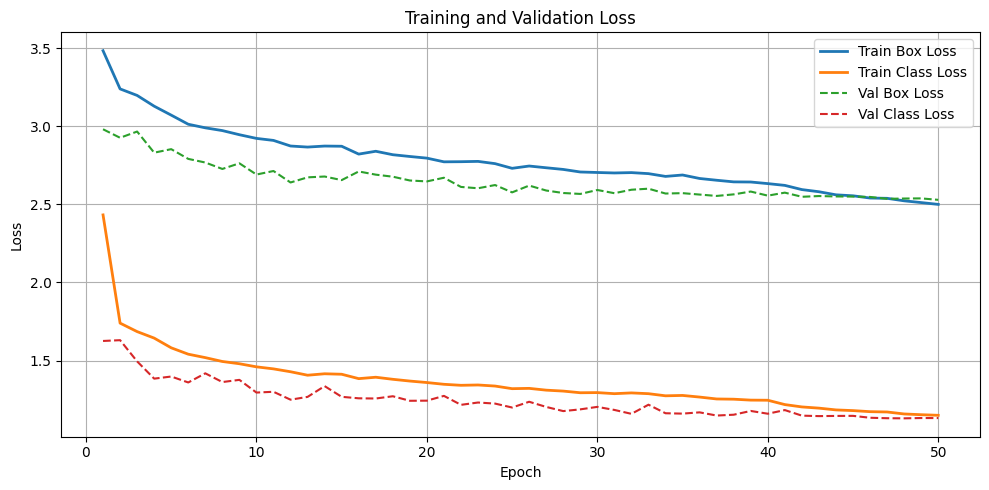

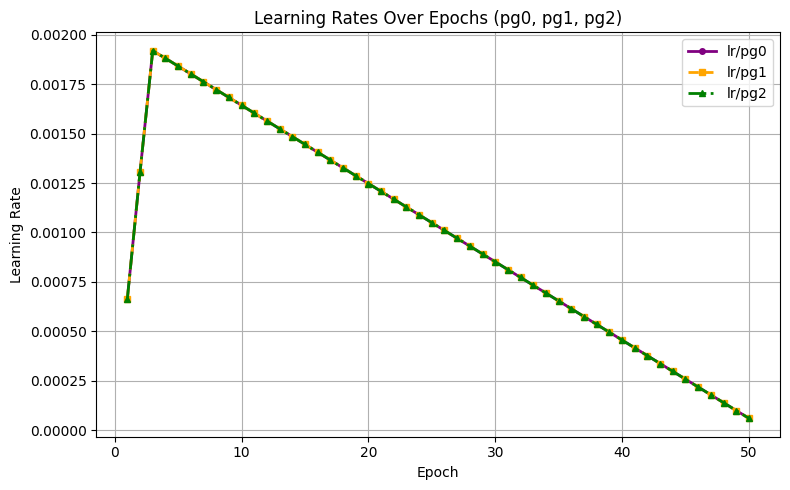

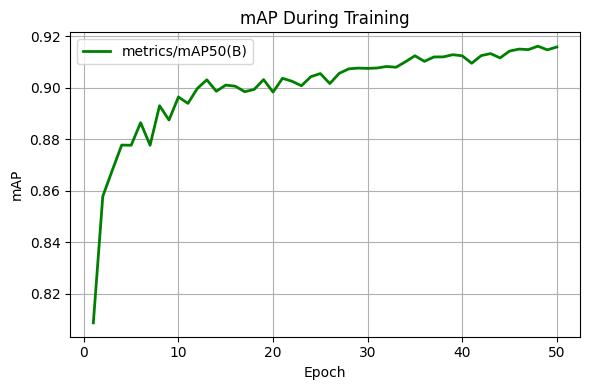

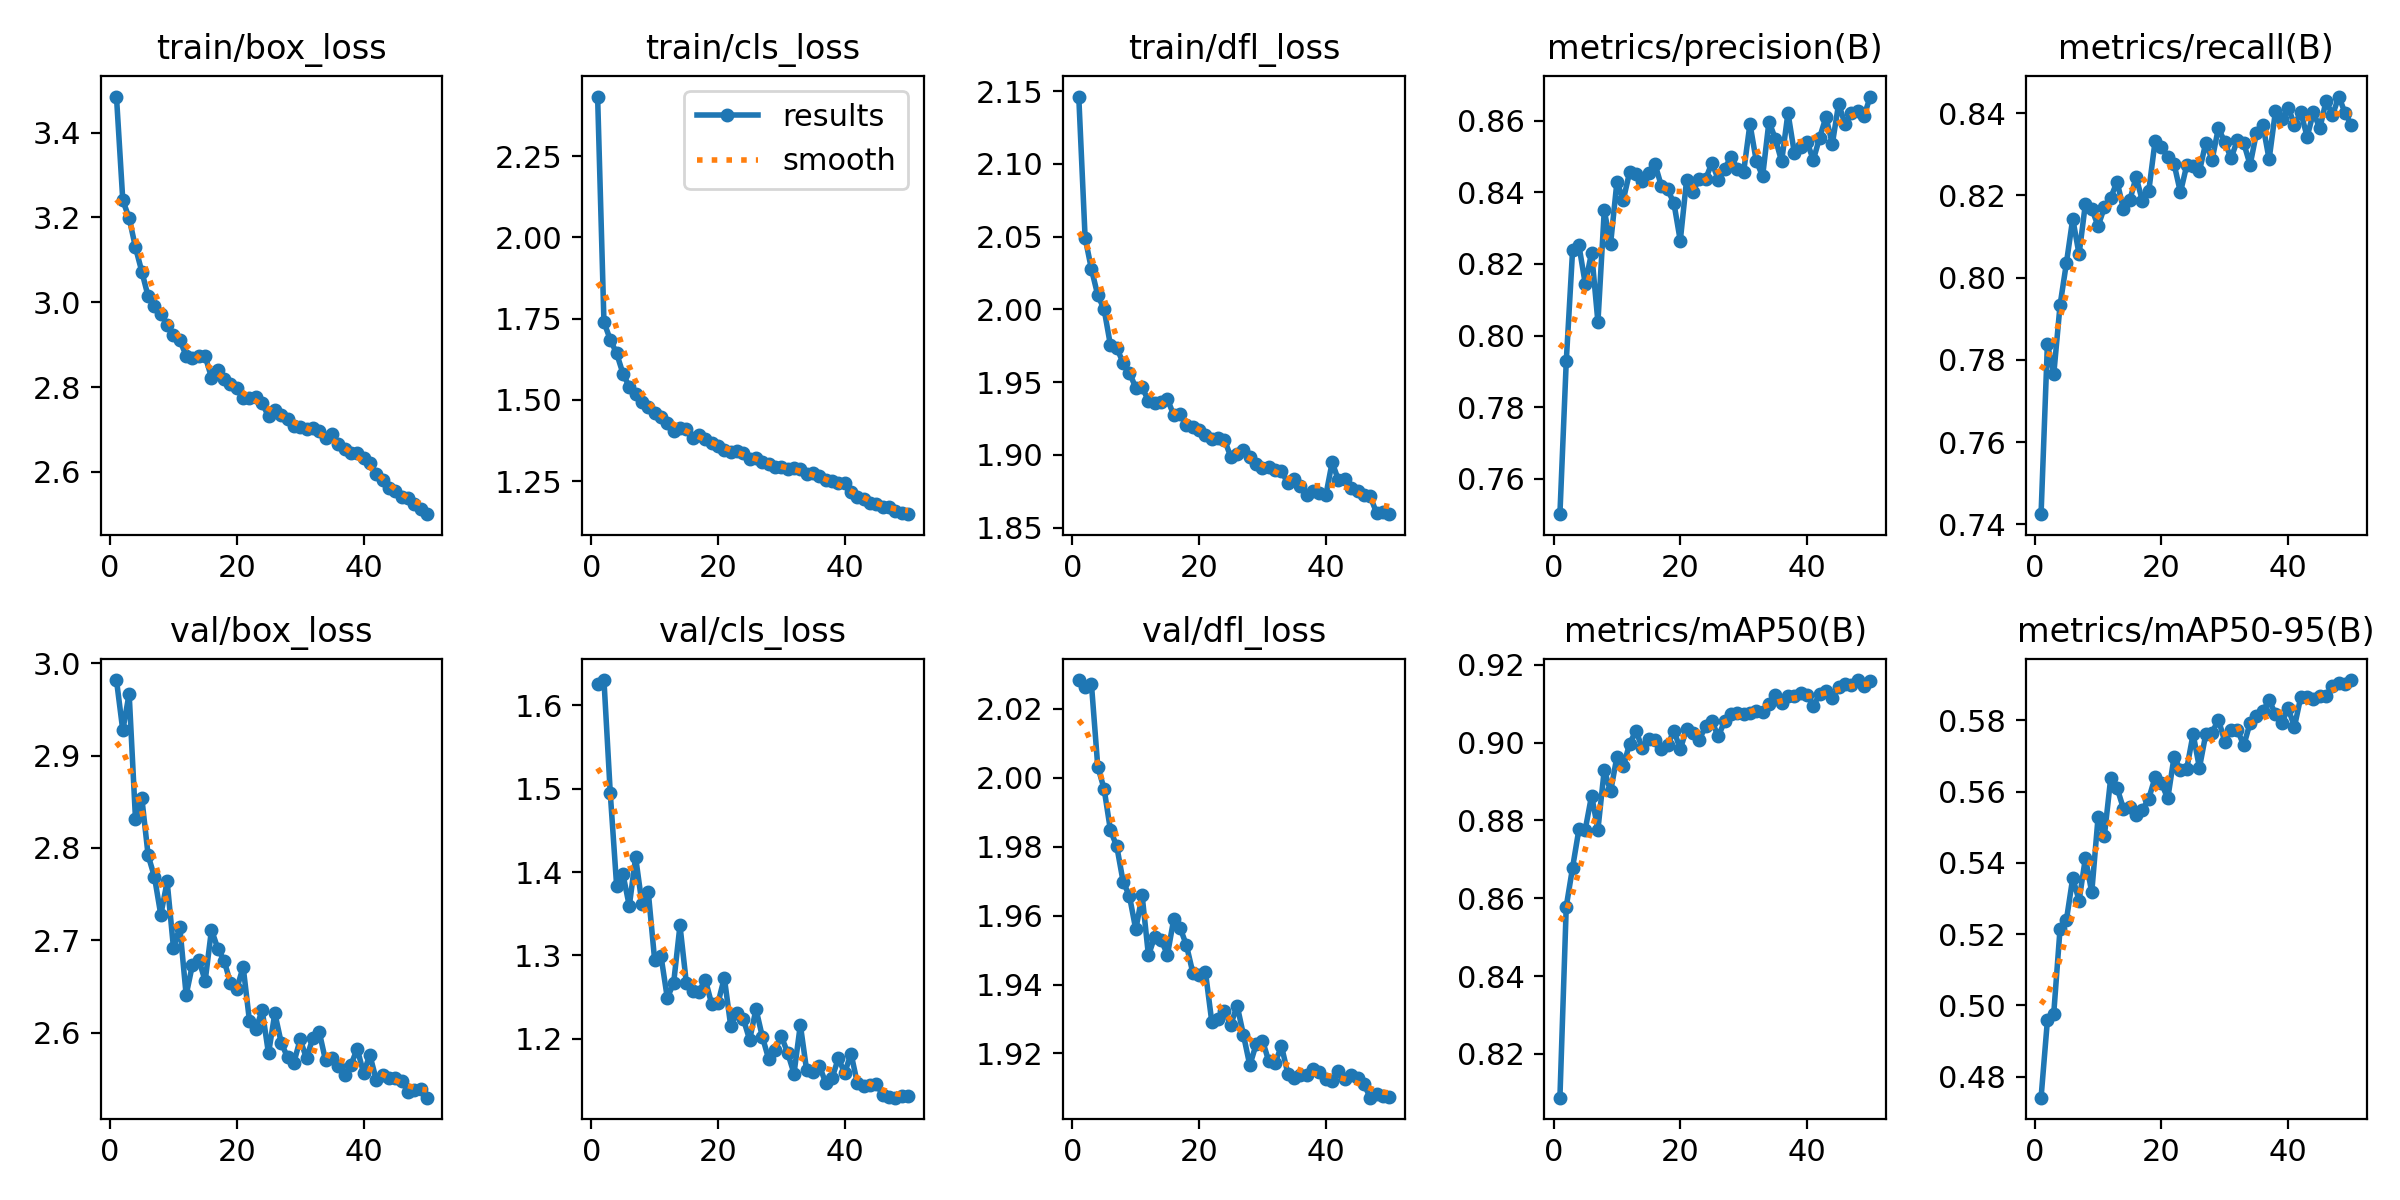

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Path to results.csv
results_path = WORK / "byol_yolo10s" / "results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")


# Plot mAP Curve (0.5 IoU)
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")



from PIL import Image
from IPython.display import display

results_img = WORK / "byol_yolo10s" / "results.png"
img = Image.open(results_img)
display(img)

## 12. Evaluation and Visualization


 Evaluating …
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1817.1±931.8 MB/s, size: 101.9 KB)


val: Scanning /kaggle/working/SSL-BYOL/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:08<00:00,  4.70it/s]


                   all        165      13823      0.867      0.838      0.916      0.591
Speed: 1.0ms preprocess, 45.7ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val

Validation metrics
Precision (mP)   : 0.8667
Recall (mR)      : 0.8375
mAP@0.50         : 0.9156
mAP@0.50:0.95    : 0.5911
Visualising: MVI_9981-MP4_frame30_jpg.rf.8870eb892c9aa91894ec04ec601f5633.jpg
Visualising: 20240206_131856-mp4_frame40_jpg.rf.ac5c891c47365745cf033c1b51f5db1a.jpg
Visualising: MVI_9825-MP4_frame1_jpg.rf.5b535dc819659b4c747a06fdeda3ad77.jpg
Visualising: 20240206_132004-mp4_frame56_jpg.rf.3c65a4812caa55da9606228f9906fa6f.jpg


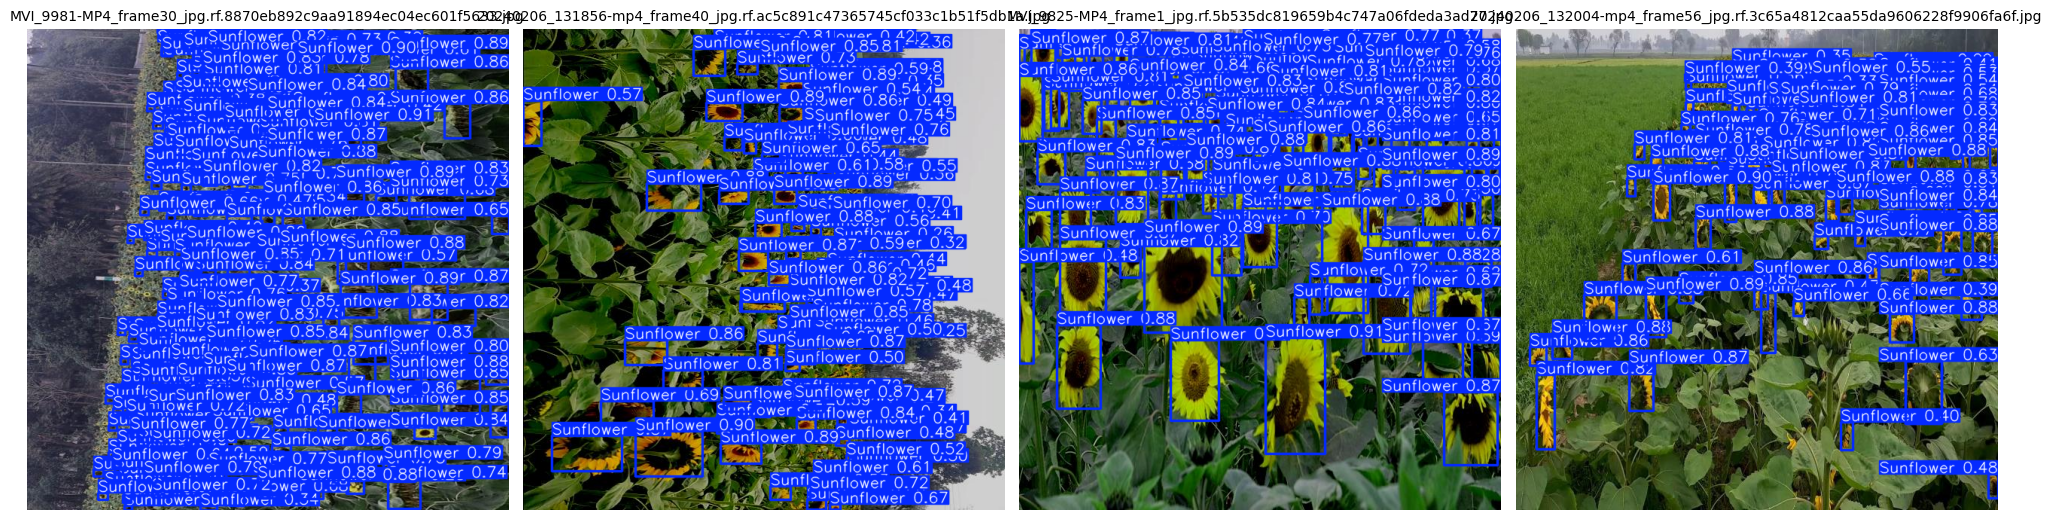

In [16]:

print("\n Evaluating …")
best_pt = WORK / "byol_yolo10s"/"weights"/"best.pt"
model   = YOLO(str(best_pt))
results = model.val(data=str(DATA), imgsz=640, batch=4, device=0 if device=="cuda" else None)

try:
    mp,mr,map50,map5095 = results.mean_results()
    print("\nValidation metrics")
    print(f"Precision (mP)   : {mp:.4f}")
    print(f"Recall (mR)      : {mr:.4f}")
    print(f"mAP@0.50         : {map50:.4f}")
    print(f"mAP@0.50:0.95    : {map5095:.4f}")
except Exception:
    print("Ultralytics API changed; raw results follows:")
    print(results)

import random

# pick from test or valid images
cands = list((WORK/"test"/"images").glob("*.*")) or list((WORK/"valid"/"images").glob("*.*"))

if cands:
    imgs = random.sample(cands, min(4, len(cands)))  # pick up to 4 random images
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    axes = axes.flatten()

    for ax, img_path in zip(axes, imgs):
        print("Visualising:", img_path.name)
        pred = model.predict(
            source=str(img_path),
            imgsz=640,
            conf=0.25,
            device=0 if device == "cuda" else None,
            verbose=False
        )[0]
        ax.imshow(pred.plot()[:,:,::-1])
        ax.axis("off")
        ax.set_title(img_path.name, fontsize=10)

    # hide unused axes if <4 images
    for ax in axes[len(imgs):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

else:
    print("No images found for visualization.")

